<a href="https://colab.research.google.com/github/tedteske/PintwoodDerbyStats/blob/main/Pintwood_Derbystats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pack 27 Pinewood Derby 2022 Results

First, import the libraries we'll need and load the CSV results files into a Pandas dataframe.

In [1]:
#see https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [35]:
import glob
import os
import pandas as pd
import statsmodels.formula.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,5)})
plt.rcParams["font.family"] = "serif"

import warnings 
warnings.simplefilter('ignore')

def top_times(df, filter_dict=None, means=True, top=10):
    '''
    Print dataframe of top times.
    
    Parameters
    ----------
    df : dataframe of race data
    filter_dict : dictionary, filter used to narrow results by column values
    means : bool, if True, return mean time, grouped by car
    top : int, number of top times to display
    '''
    if filter_dict:
        df = df[df.isin(filter_dict).sum(1) == len(filter_dict.keys())]
        # adapted from https://stackoverflow.com/questions/38137821
    df = df[['Car', 'Last Name', 'First Name', 'Lane', 'Time']]
    if means:
        aggs = {'Time':['mean','std']}
        df = df.groupby(['Car','Last Name','First Name']).agg(aggs)
        df.columns = ['Time', 'Stdev']
    mu = df['Time'].mean()
    stdev = df['Time'].std()
    df['Z-score'] = (df['Time'] - mu)/stdev
    df = df.sort_values('Time')
    df = df.head(top)
    df = df.reset_index()
    df.index += 1 
    return df

def most_improved(df, year_A, year_B, top=10):
    '''
    Print dataframe of scouts who improved the most between year_A and year_B.
    
    Parameters
    ----------
    df : dataframe of race data
    year_A : text string
    year_B : text string
    top : int, number of top times to display
    '''
    name_columns = ['Last Name','First Name']
    pA_df = top_times(df, {'Year': [year_A]}, means=True, top=None)
    pB_df = top_times(df, {'Year': [year_B]}, means=True, top=None)
    inner_df = pd.merge(left=pA_df, right=pB_df, 
                        left_on=name_columns, right_on=name_columns,
                        suffixes=('_' + year_A, '_' + year_B))
    TimeA_col = 'Time_' + year_A
    TimeB_col = 'Time_' + year_B
    inner_df = inner_df[['Last Name','First Name', TimeB_col, TimeA_col]]
    inner_df['Diff'] = inner_df[TimeB_col] - inner_df[TimeA_col]
    inner_df = inner_df.sort_values('Diff').head(top)
    inner_df = inner_df.reset_index()
    inner_df.index += 1 
    return inner_df

def rookies(df, year):
    '''
    Return dataframe of race data from rookies only.
    
    Parameters
    ----------
    df : dataframe of race data
    year : text string
    '''
    aggs = {'Year':['max','nunique']}
    df0 = df.groupby(['Last Name','First Name']).agg(aggs)
    df0.columns = ['Year', 'Tenure']
    df0 = df0[(df0["Year"]==year) & (df0["Tenure"]==1)]
    df0.drop(['Year', 'Tenure'], axis=1, inplace=True)
    df0.reset_index(inplace=True)
    rookies_df = df.merge(df0, on=['Last Name', 'First Name'])
    return rookies_df

def derby_regression(df, years):
    '''
    Print results of regression of Time on (presumed) factors most 
    influencing it.
    
    Parameters
    ----------
    df : dataframe of race data
    years : list of text strings, years to include in data to be analyzed 
    '''
    df = df[df.Year.isin(years)]

    # assign ages to preliminary heat cohorts
    for i in zip(['Lion', 'Tiger', 'Wolf', 'Bear', 'Webelo', 'AOL'], range(6)):
        df.loc[df['Round']==i[0],'Age'] = i[1]
    df.loc[df['Round']=='LiTiWolf', 'Age'] = 1 #assume the avg is a Tiger
    df.loc[df['Round']=='WebAOL', 'Age'] = 4.5 #middle between Web and AOL
    df.loc[df['Round']=='prelims', 'Age'] = 2.5 #middle between Tiger and AOL
    
    for i in [2,3,4,5,6]: 
        df.loc[df['Lane']==i,'Lane'+str(i)] = 1
    df.loc[df['Last Name']=='Schoonover','Schoonover'] = 1
    for n in ['Age', 'Lane2','Lane3','Lane4','Lane5','Lane6', 'Schoonover']:
        df[n].fillna(0, inplace=True)
    reg_form = "Time ~ Age + Lane2 + Lane3 + Lane4 + Lane5 + Lane6 + Schoonover"
    result = sm.ols(formula=reg_form, data=df).fit()
    print(result.summary())
    return None

def derby_regression_pintwood(df, years):
    '''
    Print results of regression of Time on (presumed) factors most 
    influencing it.
    
    Parameters
    ----------
    df : dataframe of race data
    years : list of text strings, years to include in data to be analyzed 
    '''
    df = df[df.Year.isin(years)]
   
    for i in [2,3,4,5,6]: 
        df.loc[df['Lane']==i,'Lane'+str(i)] = 1
    df.loc[df['Car'].isin([4,5,7,8,13,14,22]),'Pack27'] = 1
    for n in ['Lane2','Lane3','Lane4','Lane5','Lane6', 'Pack27']:
        df[n].fillna(0, inplace=True)
    reg_form = "Time ~ Lane2 + Lane3 + Lane4 + Lane5 + Lane6 + Pack27"
    result = sm.ols(formula=reg_form, data=df).fit()
    print(result.summary())
    return None

def compare_hist(df, comps_dict, filter_dict=None, 
                 title=None, hist=True, norm_hist=True, kde=True, fit=None):
    '''
    Plot comparable histograms of race data on the same graph.
    
    Parameters
    ----------
    df : dataframe of race data
    comps_dict : dictionary of keys (field names) and values used as a basis of 
        comparison between plots
    filter_dict : dictionary of keys and values used to filter data used across 
        all plots
    title : text string, title at top of graph
    hist : bool, If True, plot a histogram.
    norm_hist : bool, If True, histogram height is a density, instead of count.
    kde : bool, If True, plot a kernel density estimate.
    fit : "random variable object, optional, An object with fit method, 
        returning a tuple that can be passed to a pdf method a positional 
        arguments following a grid of values to evaluate the pdf on." 
        (from seaborn.distplot)
    '''
    if filter_dict:
        df = df[df.isin(filter_dict).sum(1) == len(filter_dict.keys())]
    plots = len(comps_dict)
    fig, axes = plt.subplots(plots, 1, 
                             figsize=(10, plots * 10/1.6), sharex=True)
    if plots > 1:
        axes = axes.flat
    else:
        axes = [axes]
    for ax, column in zip(axes, comps_dict):
        for value in comps_dict[column]:
            try:
                fseries = df[df[column].isin([value])]['Time']
            except:
                column = column[:-1]
                fseries = df[df[column].isin([value])]['Time']
            sns.distplot(fseries,
                label=value,
                hist=hist,
                norm_hist=norm_hist,
                kde=kde, kde_kws={'fill':False},
                fit=fit,
                bins=None,
                ax=ax, axlabel=False)
            if kde: 
                c = ax.get_lines()[-1].get_c()
                ax.axvline(fseries.mean(), color=c, linestyle='--')
                legend_title = "------  averages" 
            else: 
                legend_title = None
            if norm_hist:
                ax.set(ylabel='relative frequency')
            else: 
                ax.set(ylabel='frequency')
            leg = ax.legend(title=legend_title, title_fontsize='medium')
            leg._legend_box.align = "left"
    axes[-1].set(xlabel='time (sec)')
    if title: 
        fig.suptitle(title)
        fig.subplots_adjust(top=0.93)
    plt.subplots_adjust(hspace=0.07)
    plt.show()
    return None

In [3]:
data_dir = "/content/gdrive/My Drive/Colab Notebooks/scouts/Pintwood Derby"
year_dirs = ["2022"]
col_dict = {"Heat#" : "Heat",
            "Car#" : "Car", 
            "Avg MPH" : "MPH" }
prelims_list = ['2022PintwoodA', '2022PintwoodB','2022PintwoodC',
                '2022PintwoodD','2022PintwoodE']
finals_list = ['2022PintwoodFinals']
disregard_list = []

# Iterate through data directory and import *.csv files into dataframe.
temp_list = []
for year_dir in year_dirs:
    results_files = glob.glob(data_dir + "/" + year_dir + "/" + "*.csv")
    for results_file in results_files:
        df = pd.read_csv(results_file, index_col=None, header=0)
        results_file = os.path.basename(results_file) 
        df['Round'] = results_file.replace('.csv', '')
        df['Year'] = year_dir
        df.rename(columns=col_dict, inplace=True)
        temp_list.append(df)
all_results_df = pd.concat(temp_list, axis = 0, ignore_index = True)
null_times_rows = all_results_df[all_results_df["Time"].isnull()].index
all_results_df = all_results_df.drop(null_times_rows, axis=0)
all_results_df = all_results_df[~all_results_df.Round.isin(disregard_list)]

# Scan for misspelled names and fix.
Names_Fixes = []
for i in Names_Fixes:
    all_results_df.loc[(all_results_df['Last Name'] == i[0]) & 
                        (all_results_df['First Name'] == i[1]),
                    ['Last Name', 'First Name']]=[i[2], i[3]]

prelims_df = all_results_df[all_results_df.Round.isin(prelims_list)]
finals_df = all_results_df[all_results_df.Round.isin(finals_list)]

### Preliminary Rounds

Let's compare the preliminary rounds with previous years. First, run the usual stats.

In [4]:
prelims_df.groupby(['Year'])['Time'].describe().round(3).T

Year,2022
count,174.000
mean,3.494
std,0.723
min,3.003
25%,3.092
50%,3.242
75%,3.643
max,10.000


Here are the same stats broken down by den. Note that there were no den-level heats in 2021 due to not having enough competitors. In 2022, Lions, Tigers, and Wolves were grouped together and so were Webelos and AOLs.

In [5]:
prelims_df.groupby(['Year', 'Round'])['Time'].describe().round(3).T

Year           2022                                                        
Round 2022PintwoodA 2022PintwoodB 2022PintwoodC 2022PintwoodD 2022PintwoodE
count        36.000        36.000        36.000        36.000        30.000
mean          3.605         3.204         3.492         3.234         4.021
std           1.202         0.118         0.613         0.219         0.597
min           3.025         3.047         3.006         3.003         3.061
25%           3.068         3.133         3.090         3.038         3.641
50%           3.238         3.151         3.236         3.230         4.333
75%           3.752         3.341         3.530         3.267         4.476
max          10.000         3.417         4.960         3.731         5.034

How many cars participated by year?

In [6]:
prelims_df.groupby(['Year'])['Car'].nunique()

Year
2022    29
Name: Car, dtype: int64

It appears that 2022 was the fastest year so far. Test whether the difference is significant or just chance.

In [7]:
stats.ttest_ind(prelims_df[prelims_df.Year.isin(['2021'])]['Time'], 
                prelims_df[prelims_df.Year.isin(['2022'])]['Time'])

Ttest_indResult(statistic=nan, pvalue=nan)

In [ ]:
stats.ttest_ind(prelims_df[prelims_df.Year.isin(['2020'])]['Time'], 
                prelims_df[prelims_df.Year.isin(['2022'])]['Time'])

Ttest_indResult(statistic=0.5026001296332571, pvalue=0.6155063774610241)

In [ ]:
stats.ttest_ind(prelims_df[prelims_df.Year.isin(['2020'])]['Time'], 
                prelims_df[prelims_df.Year.isin(['2021'])]['Time'])

Ttest_indResult(statistic=-0.17963536562044055, pvalue=0.8575340848971206)

Since the above pvalues > 0.05, we cannot reject the null hypothesis that the samples (2020, 2021, and 2022) are drawn from the same process. In other words, 2022 was not a *significant* improvement over 2020 or 2021. Pretty much a tie.

In [ ]:
stats.ttest_ind(prelims_df[prelims_df.Year.isin(['2019'])]['Time'], 
                prelims_df[prelims_df.Year.isin(['2022'])]['Time'])

Ttest_indResult(statistic=3.3292685443829186, pvalue=0.0009407348086230581)

However, since this pvalue < 0.05, we *can* reject the null hypothesis that the samples (2019 and 2022) are drawn from the same process. In other words, 2022 was a *significant* improvement over 2019. 

Let's see what the distribution of times looks like by drawing a histogram, or frequency distribution, of each of the last 2 years.

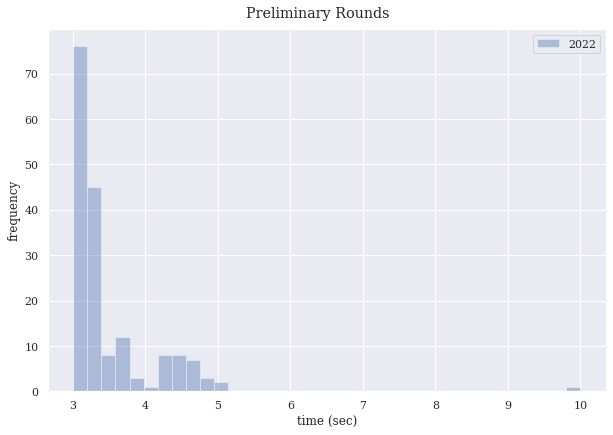

In [8]:
comps = {'Year' : ["2022"]}
compare_hist(prelims_df, comps, title="Preliminary Rounds",
         hist=True, norm_hist=False, kde=False)

As there were fewer competitors in 2021, let's normalize the results. Also, to facilitate year-to-year comparisons, we'll smooth the histograms and add lines representing average time by year.

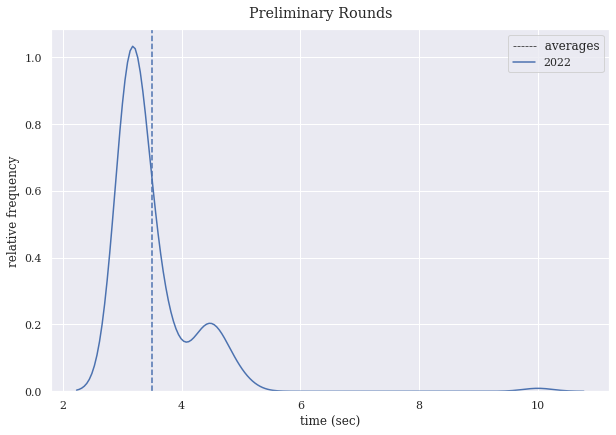

In [10]:
comps = {'Year' : ["2022"]}
compare_hist(prelims_df, comps, title="Preliminary Rounds",
         hist=False, norm_hist=True, kde=True)

We see that the years 2020-2022 had close to the same average time and spread of times. 2019 was not only slower but less consistent: the times were distributed less tightly around the average.

Average Time by car in the prelims, the top 10. Z-score, or standard score, indicates how fast each car was that in terms of standard deviations from the overall average. See https://en.wikipedia.org/wiki/Standard_score for more info.

In [11]:
filter_dict = {'Year' :['2022']}
top_times(prelims_df, filter_dict, means=True, top=10)

,Car,Last Name,First Name,Time,Stdev,Z-score
1,23,Hein,Owen,3.011017,0.006761,-0.785382
2,4,Green,Luke,3.029083,0.005142,-0.755992
3,13,Schoonover,Daniel,3.031633,0.024723,-0.751843
4,24,Melton,Larry,3.047767,0.014450,-0.725598
5,5,Evers,Lindel,3.066517,0.009292,-0.695095
6,26,Martin,Josh,3.079633,0.015445,-0.673757
7,8,Schoonover,Lacey,3.095217,0.099888,-0.648406
8,9,Mitchell,Rick,3.135800,0.005145,-0.582385
9,7,Pool,Jason,3.137250,0.010669,-0.580027
10,10,Tharp,Stephen,3.155983,0.007077,-0.549551


And here are the top 10 individual Times in the prelims.

In [12]:
filter_dict = {'Year' :['2022']}
top_times(prelims_df, filter_dict, means=False, top=10)

,index,Car,Last Name,First Name,Lane,Time,Z-score
1,124,23,Hein,Owen,5,3.0034,-0.678149
2,131,23,Hein,Owen,6,3.0037,-0.677734
3,179,13,Schoonover,Daniel,6,3.0060,-0.674553
4,117,23,Hein,Owen,4,3.0100,-0.669022
5,110,23,Hein,Owen,3,3.0133,-0.664459
6,132,23,Hein,Owen,1,3.0149,-0.662246
7,151,13,Schoonover,Daniel,2,3.0160,-0.660725
8,139,23,Hein,Owen,2,3.0208,-0.654087
9,144,13,Schoonover,Daniel,1,3.0222,-0.652151
10,165,13,Schoonover,Daniel,4,3.0226,-0.651598


Of those scouts who competed in both 2021 and 2022, who improved the most?

In [ ]:
most_improved(prelims_df, '2021', '2022')

,index,Last Name,First Name,Time_2022,Time_2021,Diff
1,9,Douthitt,Savannah Rose,3.315217,4.091233,-0.776017
2,8,Adams,Jonathan,3.335600,3.668133,-0.332533
3,2,Schoonover,Isaac,3.124933,3.201433,-0.076500
4,3,Evers,Charlie,3.164500,3.216200,-0.051700
5,0,Schoonover,Aubrey,3.119600,3.165367,-0.045767
6,1,Schoonover,Adelyn,3.147100,3.185933,-0.038833
7,4,Teske,Pippa,3.258367,3.223000,0.035367
8,6,Magann,Mason,3.461517,3.348767,0.112750
9,5,McCabe,Madison,3.556133,3.279867,0.276267
10,7,Douthitt,Brianna Lynn,3.872850,3.381700,0.491150


2021 had relatively few competitors, so of those scouts who competed in both 2020 and 2022, who improved the most?

In [ ]:
most_improved(prelims_df, '2020', '2022')

,index,Last Name,First Name,Time_2022,Time_2020,Diff
1,11,Teske,Pippa,3.258367,3.512283,-0.253917
2,10,Franken,Zayne,3.368200,3.509050,-0.140850
3,3,Schoonover,Aubrey,3.119600,3.192467,-0.072867
4,1,Schoonover,Isaac,3.124933,3.183133,-0.058200
5,6,Adams,Jonathan,3.335600,3.384783,-0.049183
6,5,Douthitt,Savannah Rose,3.315217,3.347433,-0.032217
7,2,Evers,Charlie,3.164500,3.192350,-0.027850
8,9,Pool,Oliver,3.449300,3.453367,-0.004067
9,0,Schoonover,Adelyn,3.147100,3.141383,0.005717
10,7,Magann,Mason,3.461517,3.399567,0.061950


Who were the top 10 rookies in 2022?

In [ ]:
rookies_df =  rookies(prelims_df, '2022')
filter_dict = {'Year' :['2022']}
top_times(rookies_df, filter_dict, means=True, top=10)

,Car,Last Name,First Name,Time,Stdev,Z-score
1,34,Kennedy,Salem,3.200733,0.013302,-1.269633
2,2,Von Tunglen,Hudson,3.252833,0.043648,-0.859421
3,19,Tipton,Frances,3.264367,0.018084,-0.768613
4,1,Von Tunglen,Mira,3.287883,0.041069,-0.583454
5,11,Pool,James,3.311150,0.027069,-0.400262
6,30,Doyle,Dean,3.315267,0.017540,-0.367850
7,10,Pool,Jasper,3.315483,0.030429,-0.366144
8,14,Arreaga,Axel,3.406933,0.132270,0.353892
9,37,Nwamara,Joshua,3.508300,0.051530,1.152007
10,36,Green,Jane,3.555567,0.032879,1.524163


### Finals Rounds

Now let's compare the Finals round with previous years. First, run the usual stats.

In [13]:
finals_df.groupby(['Year'])['Time'].describe().round(3).T

Year,2022
count,72.000
mean,3.092
std,0.112
min,3.009
25%,3.038
50%,3.064
75%,3.126
max,3.915


It appears that 2022 was faster than the previous best year 2019. Test whether the difference is significant or just chance.

In [ ]:
stats.ttest_ind(finals_df[finals_df.Year.isin(['2019'])]['Time'],
                finals_df[finals_df.Year.isin(['2022'])]['Time'])

Ttest_indResult(statistic=7.4934980254511085, pvalue=6.561849563592493e-12)

Since the pvalue<0.05, we can reject the null hypothesis that the samples (2019 and 2022) are drawn from the same process. In other words, 2022 was significantly faster than 2019 (and any other year).

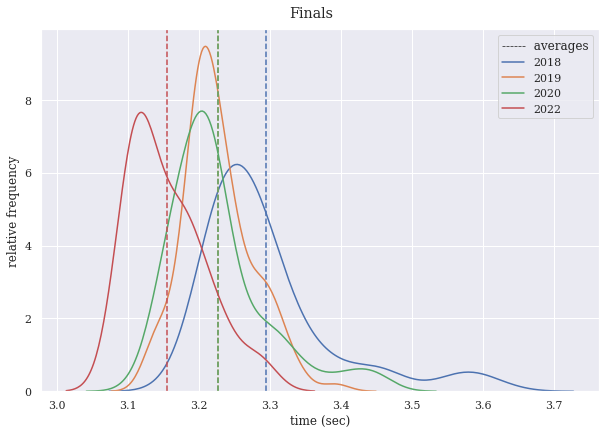

In [ ]:
comps = {'Year' : [ '2018', '2019', '2020', '2022']}
compare_hist(finals_df, comps, title="Finals",
         hist=False, norm_hist=True, kde=True)

Average Time by car in the 2022 finals.

In [31]:
filter_dict = {'Year' :['2022']}
top_times(finals_df, filter_dict,means=True)

,Car,Last Name,First Name,Time,Stdev,Z-score
1,4,Green,Luke,3.015100,0.004086,-1.178745
2,13,Schoonover,Daniel,3.025350,0.018700,-1.021318
3,23,Hein,Owen,3.031583,0.008968,-0.925581
4,24,Melton,Larry,3.042767,0.012345,-0.753819
5,5,Evers,Lindel,3.061317,0.005558,-0.468913
6,26,Martin,Josh,3.068550,0.030027,-0.357817
7,8,Schoonover,Lacey,3.087167,0.068929,-0.071888
8,10,Tharp,Stephen,3.108717,0.008745,0.259094
9,9,Mitchell,Rick,3.131117,0.009132,0.603132
10,7,Pool,Jason,3.140817,0.026068,0.752112


And here are the top 10 individual Times in the finals.

In [ ]:
filter_dict = {'Year' :['2022']}
top_times(finals_df, filter_dict,means=False)

,index,Car,Last Name,First Name,Lane,Time,Z-score
1,1438,13,Schoonover,Aubrey,5,3.0903,-1.225446
2,1446,13,Schoonover,Aubrey,1,3.0919,-1.195094
3,1445,13,Schoonover,Aubrey,6,3.0940,-1.155258
4,1431,13,Schoonover,Aubrey,4,3.1022,-0.999706
5,1453,13,Schoonover,Aubrey,2,3.1030,-0.984530
6,1424,13,Schoonover,Aubrey,3,3.1037,-0.971251
7,1439,12,Schoonover,Adelyn,6,3.1048,-0.950384
8,1433,9,Schoonover,Isaac,6,3.1104,-0.844154
9,1447,12,Schoonover,Adelyn,2,3.1171,-0.717056
10,1434,9,Schoonover,Isaac,1,3.1172,-0.715160


### Lanes, Ages and the Schoonover Effect

Are there any differences among the lanes? First run the usual stats and plot the distributions.

In [14]:
lanes_df = prelims_df[prelims_df.Year.isin(['2022'])][['Lane','Time']]
lanes_df.groupby(['Lane']).describe().round(4).T

Lane              1        2        3        4        5        6
Time count  29.0000  29.0000  29.0000  29.0000  29.0000  29.0000
     mean    3.4908   3.4790   3.4560   3.4525   3.6345   3.4500
     std     0.5905   0.5472   0.4853   0.5084   1.3238   0.5570
     min     3.0149   3.0160   3.0133   3.0100   3.0034   3.0037
     25%     3.0773   3.0996   3.1309   3.1224   3.0906   3.0949
     50%     3.2301   3.2628   3.2645   3.2319   3.2405   3.2299
     75%     3.6444   3.6985   3.7000   3.6396   3.4126   3.3820
     max     5.0341   4.8171   4.6217   4.7000   9.9999   4.9025

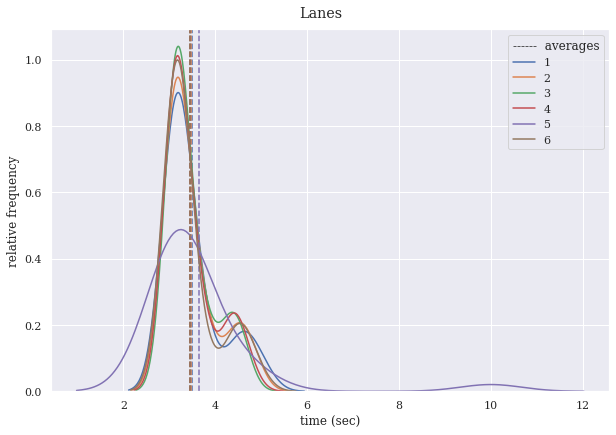

In [15]:
comps = {'Lane' : [1,2,3,4,5,6]}
compare_hist(lanes_df, comps, title="Lanes",
         hist=False, norm_hist=True, kde=True)

It looks like lane one is a slower than the others. Do we see this when comparing the lane results of the fastest car?

In [19]:
filter_dict = {'Year' :['2022'], 'Car':[22]}
top_times(prelims_df, filter_dict, means=False)

,index,Car,Last Name,First Name,Lane,Time,Z-score
1,125,22,Teske,Ted,6,3.0296,-2.036174
2,111,22,Teske,Ted,4,3.2158,0.342094
3,126,22,Teske,Ted,1,3.2161,0.345926
4,140,22,Teske,Ted,3,3.2178,0.367640
5,118,22,Teske,Ted,5,3.2253,0.463434
6,133,22,Teske,Ted,2,3.2295,0.517080


Next, run a test between each pair of lanes to determine if the lane means are significantly different.

In [20]:
lanes = [1,2,3,4,5,6]

b = [[i, j] for i in lanes for j in lanes]
combos = []
for i in b:
    if i[0]<i[1]: 
        combos.append(i)

pvalues = []
for i in combos:
    e = lanes_df["Time"][lanes_df["Lane"]==i[0]]
    f = lanes_df["Time"][lanes_df["Lane"]==i[1]]
    pvalue = round(stats.ttest_ind(e, f)[1],4)
    pvalues.append(pvalue)

pd.DataFrame({'Lane Pair': combos,
              'P-value' : pvalues}).sort_values('P-value')


,Lane Pair,P-value
14,"[5, 6]",0.4918
12,"[4, 5]",0.4923
10,"[3, 5]",0.4981
7,"[2, 5]",0.5610
3,"[1, 5]",0.5954
4,"[1, 6]",0.7875
2,"[1, 4]",0.7923
1,"[1, 3]",0.8071
8,"[2, 6]",0.8422
6,"[2, 4]",0.8494


Since, for each pair of lanes, the probability is high (p-value>0.05) that the mean Time difference is chance, we can conclude there is no significant difference among the lanes. Please note that the significance level we choose (0.05) implies a confidence level of of 95%, and that it's just a convention. Had we chosen a confidence level of 80% (significance level of 0.20), lane 1 would be said to be significantly slower than lane 4.

#### The Schoonover Effect

Yes, there is one, and it's measurable and significant. On average and when controlling for scouts' ages and lanes, having the last name 'Schoonover' reduces the Time by around 0.22 seconds in both 2019 and 2020. This effect has increased to 0.28 seconds in 2022. See the coefficient for `Schoonover` in the results below.

Also note that each additional year in a scout's age reduces their time by around 0.03 seconds in 2020, wherease the opposite is true in 2022. These results are also significant.

In [36]:
derby_regression_pintwood(prelims_df, ['2022'])

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     3.151
Date:                Sun, 06 Mar 2022   Prob (F-statistic):            0.00594
Time:                        21:07:37   Log-Likelihood:                -180.66
No. Observations:                 174   AIC:                             375.3
Df Residuals:                     167   BIC:                             397.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6153      0.133     27.197      0.0

In [ ]:
derby_regression(prelims_df, ['2020'])

                            OLS Regression Results                            
Dep. Variable:                   Time   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     7.038
Date:                Sat, 12 Feb 2022   Prob (F-statistic):           9.64e-08
Time:                        13:56:15   Log-Likelihood:                 119.20
No. Observations:                 288   AIC:                            -222.4
Df Residuals:                     280   BIC:                            -193.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4547      0.028    124.164      0.0

### Distributional Analysis and Fastest Possible Time

Let's look again at the histogram for the preliminary rounds.

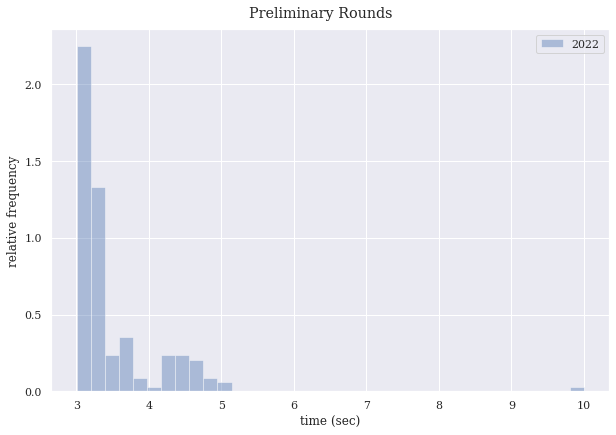

In [22]:
comps = {'Year' : ['2022']}
compare_hist(prelims_df, comps, title="Preliminary Rounds",
         hist=True, norm_hist=True, kde=False)

Can we say with confidence that the preliminaries' times are normally distributed (i.e. follow a bell curve)? Do a test for normality.

In [23]:
times = prelims_df[prelims_df.Year.isin(['2022'])]['Time']
stats.normaltest(times)

NormaltestResult(statistic=209.99583043170017, pvalue=2.5117985790101577e-46)

Since the above p-value < 0.05 , we can reject the null hypothesis that Times are distributed normally. 

The histogram appears to have a long right tail and a hard boundary on the left. Perhaps a lognormal distribution is more appropriate. Superimpose a lognormal probability density function to the histogram and check visually for goodness of fit.

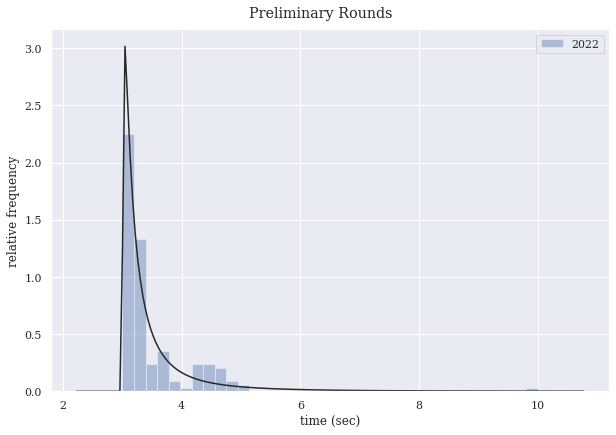

In [24]:
comps = {'Year' : ['2022']}
compare_hist(prelims_df, comps, title="Preliminary Rounds",
             hist=True, norm_hist=True, kde=False, fit=stats.lognorm)

The curve looks to fit the data well. In others words, the data appear to follow a lognormal distribution. Test for goodness of fit.

In [25]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest
stats.kstest(times, "lognorm", stats.lognorm.fit(times))

KstestResult(statistic=0.07151377639824663, pvalue=0.32172122767772754)

Since the above p-value > 0.05 , we cannot reject the null hypothesis that Times follow a lognormal distribution. Also, we know that simulating the track physics yields a lognormal distribution of race times. See https://github.com/tedteske/DerbySim/blob/master/DerbySim.ipynb for details.

Now, estimate the parameters of that distribution, and plot a historgram of random draws from it to see if it resembles the original data. 

shape =  1.2989
lower bound =  2.9955
distance from lower bound to median =  0.2352




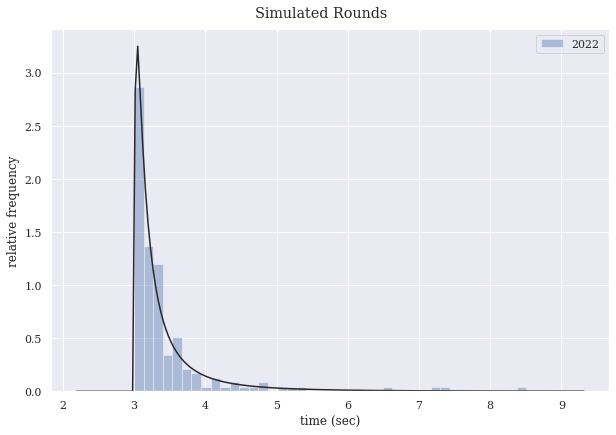

In [26]:
shape, floor, median = stats.lognorm.fit(times)

print("shape = ", shape.round(4))
print("lower bound = ", floor.round(4))
print("distance from lower bound to median = ", median.round(4))
print("\n")

dist = []
for i in range(len(times)):
    x = stats.lognorm.rvs(s=shape, loc=floor, scale=median)
    dist.append(['2022', x])

df = pd.DataFrame(dist, columns = ['Year', 'Time'])  

comps = {'Year' : ['2022']}
compare_hist(df, comps_dict=comps, title="Simulated Rounds",
         hist=True, norm_hist=True, kde=False, fit=stats.lognorm)

Yes, sure does. 

If this curve then is representative, then what is the probability that some car randomly selected from this group runs a time better than 3.2 seconds?

In [29]:
#https://matthew-brett.github.io/teaching/on_cdfs.html
stats.lognorm.cdf(x=3.2, s=shape, loc=floor, scale=median).round(4)

0.4571

...and better than 3.1 seconds?

In [30]:
stats.lognorm.cdf(x=3.1, s=shape, loc=floor, scale=median).round(4)

0.2662

...which is consistent with the lower bound of the distribution above.  Note that this is also consistent with the fastest possible time (with stock wheels and one wheel lifted) of 3.0378. 

See again https://github.com/tedteske/DerbySim/blob/master/DerbySim.ipynb for details.